In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


2025-03-12 01:25:34.858898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 01:25:35.126566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 01:25:35.302657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741742735.611329    3541 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741742735.676120    3541 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 01:25:36.331937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/'
url += 'NLP-project-tutorial/main/url_spam.csv'
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [3]:
df_raw.sample(10, random_state=2025)

,url,is_spam
1897,https://briefingday.com/fan,True
98,https://seattle.eater.com/2020/6/18/21293916/s...,False
141,https://www.buzzfeednews.com/article/tanyachen...,False
2128,https://www.nytimes.com/2020/06/29/movies/sund...,False
2953,http://gettheelevator.com/editorial,True
2537,https://www.theverge.com/2020/6/29/21304947/re...,False
1801,https://www.earios.net/,False
1024,https://old.reddit.com/r/AskReddit/comments/he...,False
37,https://www.theobservereffect.org/marc.html,False
4,https://briefingday.com/fan,True


In [4]:
df_baking = df_raw.copy()
df_baking = df_baking.drop_duplicates()
df_baking['text'] = (
    df_baking['url']
    .str.replace('://',' ')
    .str.replace('.',' ')
    .str.replace('/',' ')
    .str.replace('-',' ')
    .str.lower()
    .str.replace(r'\b\w*\d\w*\b', '', regex=True)  # Quita palabras con números
    .str.replace(r'\s+', ' ', regex=True)  # Limpia espacios múltiples
    .str.replace(r'\b(html|https|com|www)\b', '', regex=True) # Remove specific words
    .str.strip()
)


nltk.download('stopwords') # Download stopwords if not already downloaded
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_baking['text'] = df_baking['text'].apply(remove_stopwords)
df_baking = df_baking.reset_index(drop=True)
df = df_baking.copy()
df

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam,text
0,https://briefingday.us8.list-manage.com/unsubs...,True,briefingday list manage unsubscribe
1,https://www.hvper.com/,True,hvper
2,https://briefingday.com/m/v4n3i4f3,True,briefingday
3,https://briefingday.com/n/20200618/m#commentform,False,briefingday n m#commentform
4,https://briefingday.com/fan,True,briefingday fan
...,...,...,...
2364,https://www.theverge.com/2020/6/29/21306889/di...,False,theverge disney deepfake face swapping researc...
2365,https://www.smartcitiesworld.net/news/news/dee...,False,smartcitiesworld net news news deepfake techno...
2366,https://techcrunch.com/2019/07/04/an-optimisti...,False,techcrunch optimistic view deepfakes
2367,https://www.technologyreview.com/2019/12/20/13...,False,technologyreview startup claims deepfakes prot...


In [5]:
df.sample(10, random_state=2025)

,url,is_spam,text
946,https://h-proof.com/products/h-proof,False,h proof products h proof
1987,https://www.morningbrew.com/daily/stories/2020...,False,morningbrew daily stories lululemon acquires m...
225,https://www.politico.com/news/2020/06/21/takea...,False,politico news takeaways biden trump may fundra...
1422,https://www.city-journal.org/plummeting-confid...,False,city journal org plummeting confidence experts
1293,https://www.nytimes.com/2020/06/26/business/ka...,False,nytimes business kanye west yeezy gap
692,https://www.gq.com/story/underground-railroad-...,False,gq story underground railroad north korea
1153,https://ownyourcontent.wordpress.com/2019/04/0...,False,ownyourcontent wordpress paul jarvis
236,https://www.sakara.com/pages/skimm10dr,False,sakara pages
930,https://austinkleon.com/2020/06/19/learn-to-be...,False,austinkleon learn alone
135,https://www.realclearpolitics.com/articles/202...,False,realclearpolitics articles media_begging_for_a...


In [6]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify= df['is_spam'],
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify= df_train['is_spam'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((1516, 3), (379, 3), (474, 3))

In [7]:
df_train.describe().T

,count,unique,top,freq
url,1516,1516,https://www.spiked-online.com/2020/06/17/a-hea...,1
is_spam,1516,2,False,1360
text,1516,1413,apnews,27


In [8]:
(
    df_train['text']
    .str.split(expand=True)
    .stack()
    .value_counts()[:20]
)

news           176
us             148
coronavirus    113
org             92
article         86
youtube         67
morningbrew     65
story           63
nytimes         63
trump           62
daily           58
numlock         52
stories         52
new             51
world           47
substack        43
reuters         41
vox             40
covid           39
cnbc            37
Name: count, dtype: int64

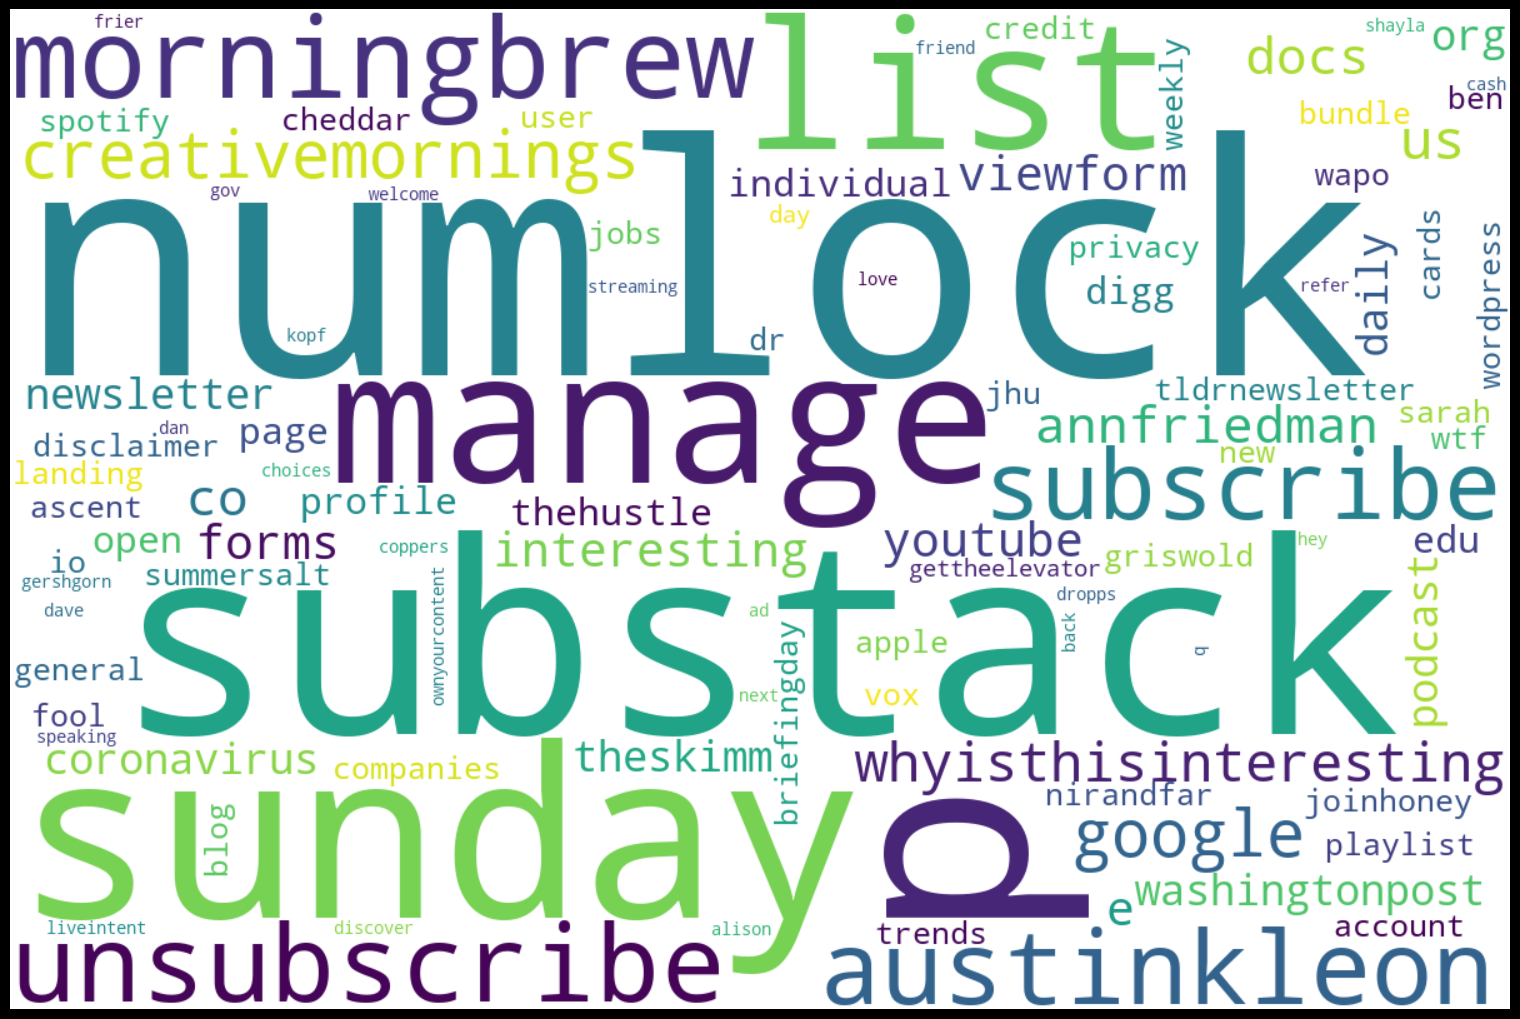

In [11]:
wordcloud = WordCloud(
    max_words=100,
    background_color='White',
    collocations=False,
    width=1200,  # Increased width
    height=800   # Increased height
).generate(' '.join(df_train[df_train['is_spam']]['text']))

plt.figure(figsize=(20,10), facecolor='k')  # Larger figure size, black background
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis
plt.tight_layout(pad=0)  # Remove padding
plt.show()

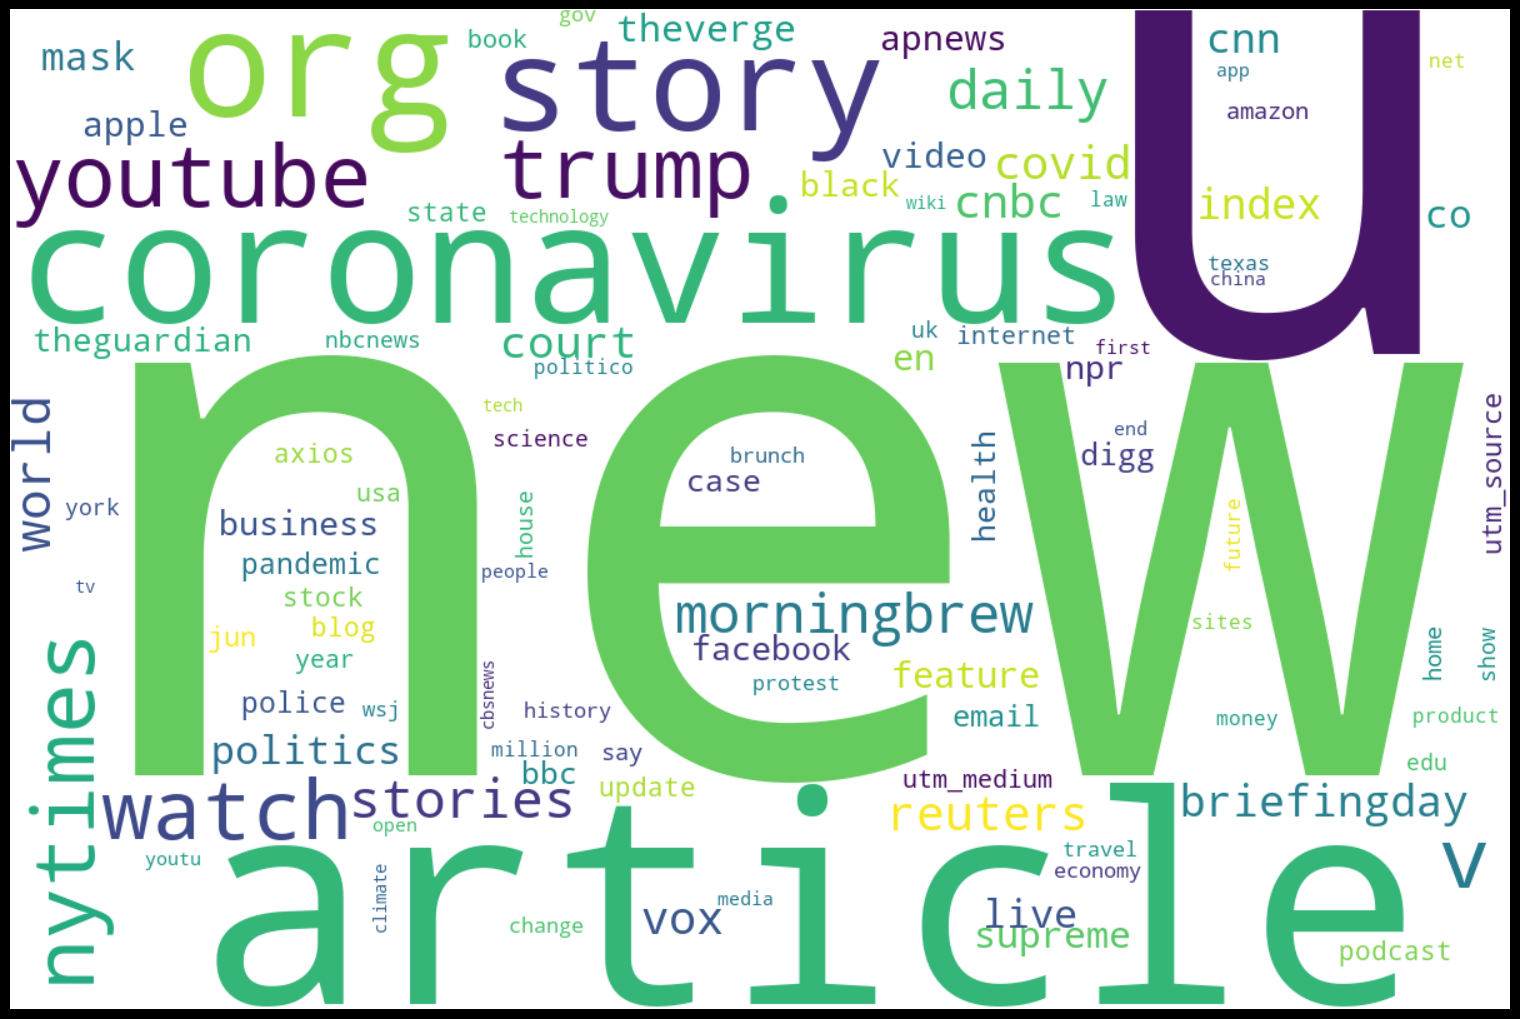

In [12]:
wordcloud = WordCloud(
    max_words=100,
    background_color='White',
    collocations=False,
    width=1200,  # Increased width
    height=800   # Increased height
).generate(' '.join(df_train[~df_train['is_spam']]['text']))

plt.figure(figsize=(20,10), facecolor='k')  # Larger figure size, black background
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis
plt.tight_layout(pad=0)  # Remove padding
plt.show()

In [13]:
X_train = df_train['text']
y_train = df_train['is_spam']
X_val = df_val['text']
y_val = df_val['is_spam']
X_test = df_test['text']
y_test = df_test['is_spam']

In [14]:
vectorizer = TfidfVectorizer(max_features=3000,ngram_range=(1,2))
X_train_v = vectorizer.fit_transform(X_train).toarray()
X_val_v = vectorizer.transform(X_val).toarray()
X_test_v = vectorizer.transform(X_test).toarray()

In [15]:
X_train_v.shape

(1516, 3000)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256,activation='relu',input_shape=(X_train_v.shape[1],)),
    tf.keras.layers.Dense(128,activation='relu'),
    #tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-12 01:29:09.178017: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       768,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,281 (3.06 MB)

 Trainable params: 801,281 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [18]:
history = model.fit(
    X_train_v,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_v,y_val)
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9088 - loss: 0.4504 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8971 - val_loss: 0.2360 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8848 - loss: 0.1920 - precision: 0.7500 - recall: 0.0911 - val_accuracy: 0.9261 - val_loss: 0.2197 - val_precision: 0.8667 - val_recall: 0.3333
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9553 - loss: 0.1150 - precision: 0.9389 - recall: 0.6092 - val_accuracy: 0.9235 - val_loss: 0.2429 - val_precision: 0.7083 - val_recall: 0.4359
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9853 - loss: 0.0604 - precision: 0.9318 - recall: 0.8800 - val_accuracy: 0.9129 - val_loss: 0.2765 - val_precision: 0.5938 - val_recall: 0.4872
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9924 - loss: 0.0358 - precision: 0.9723 - recall: 0.9576 - val_accuracy: 0.9182 - val_l

In [19]:
model.evaluate(X_test_v,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9449 - loss: 0.3243 - precision: 0.7725 - recall: 0.6522 


[0.38871532678604126, 0.9345991611480713, 0.75, 0.5510203838348389]

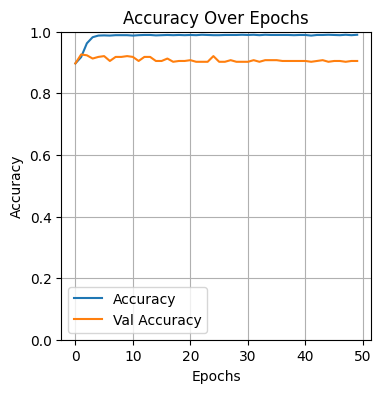

In [20]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()